# ML Foundations Assignment II – Masterclass Version

**Student:** Jad Chebly

**GitHub Repository:** https://github.com/jadchebly/ML-fundamentals-2025.git
## Predicting Hourly Bike Rentals: In-Depth Analysis

The notebook is organized into the following tasks:

1. Exploratory Data Analysis (EDA)
2. Data Splitting
3. Feature Engineering
4. Baseline Model – Linear Regression
5. Random Forest Regressor
6. Gradient Boosting Regressor
7. Hyperparameter Tuning
8. Iterative Evaluation and Refinement
9. Final Model Selection and Testing


In [35]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import pi

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

## Task 1: Exploratory Data Analysis (EDA)

### Data Overview

We start by loading the dataset and reviewing its structure. The target variable `cnt` (bike rental count) will be our focus. We also inspect temporal features like `hr` and `weekday` to uncover any cyclic patterns that may guide our later feature engineering.

In [36]:
# Load the dataset
df = pd.read_csv('hour.csv')
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Target Variable Analysis

We plot the distribution of `cnt` to examine its spread and skewness. A high skewness indicates that special attention might be needed when interpreting model errors.

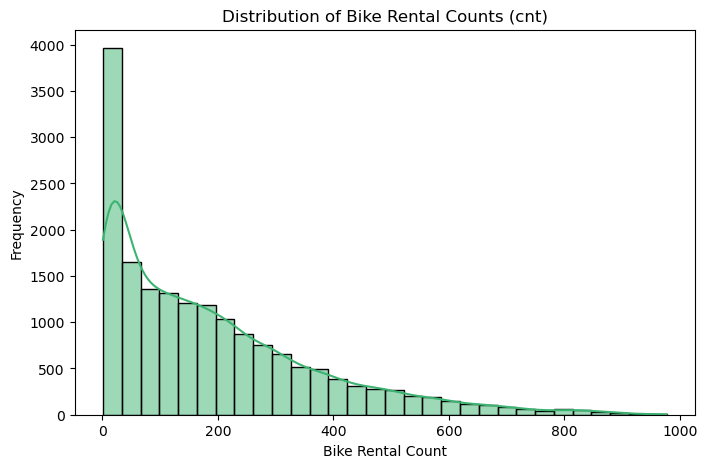

Skewness of cnt: 1.28


In [37]:
# Distribution of the target variable 'cnt'
plt.figure(figsize=(8,5))
sns.histplot(df['cnt'], kde=True, bins=30, color='mediumseagreen')
plt.title('Distribution of Bike Rental Counts (cnt)')
plt.xlabel('Bike Rental Count')
plt.ylabel('Frequency')
plt.show()

print('Skewness of cnt:', round(df['cnt'].skew(), 2))

### Temporal and Seasonal Patterns

Next, we use boxplots to investigate how `cnt` varies by hour and weekday. This gives us insight into the cyclic behavior of bike rentals throughout the day and the week.

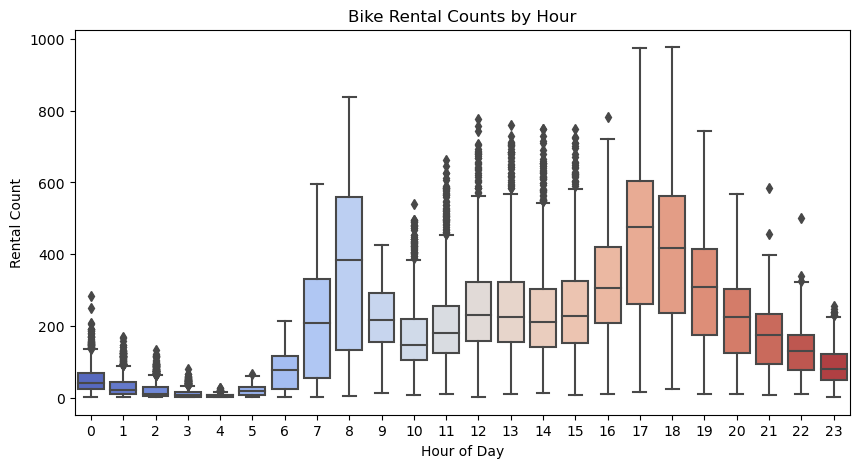

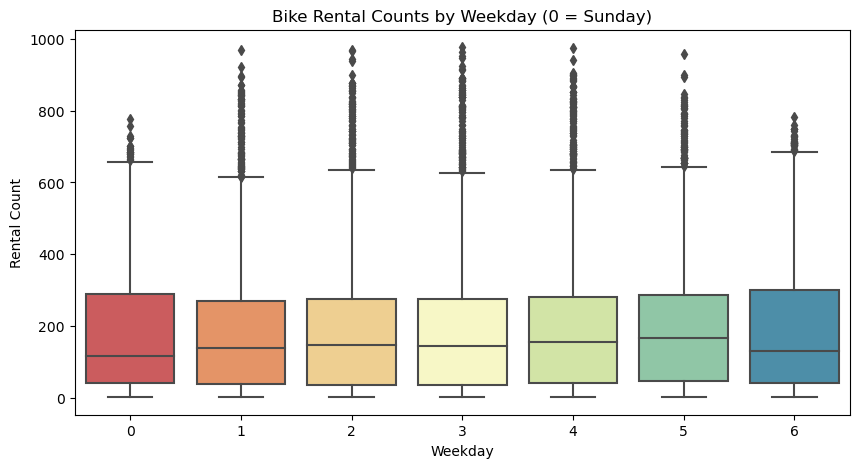

In [38]:
# Rental count variation by hour
plt.figure(figsize=(10,5))
sns.boxplot(x='hr', y='cnt', data=df, palette='coolwarm')
plt.title('Bike Rental Counts by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Rental Count')
plt.show()

# Rental count variation by weekday (0 = Sunday)
plt.figure(figsize=(10,5))
sns.boxplot(x='weekday', y='cnt', data=df, palette='Spectral')
plt.title('Bike Rental Counts by Weekday (0 = Sunday)')
plt.xlabel('Weekday')
plt.ylabel('Rental Count')
plt.show()

### Removing Non-Predictive Variables

Columns such as `instant`, `dteday`, `casual`, and `registered` are identifiers or leak target information. They are therefore dropped from further analysis.

In [39]:
# Drop columns that are not useful for prediction
cols_to_drop = ['instant', 'dteday', 'casual', 'registered']
df.drop(columns=cols_to_drop, inplace=True)
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


## Task 2: Data Splitting

To simulate a realistic forecasting problem, we split the dataset sequentially into training (60%), validation (20%), and test (20%) sets. This preserves the temporal order and prevents future information from contaminating the training process.

In [40]:
# Compute indices for sequential splitting
n = len(df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

# Create train, validation, and test sets
train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Test set shape:', test_df.shape)

Training set shape: (10427, 13)
Validation set shape: (3476, 13)
Test set shape: (3476, 13)


## Task 3: Feature Engineering

This stage enhances our dataset with essential transformations:

1. **Cyclical Encoding:** Since hours and weekdays are cyclic (e.g., hour 23 is close to hour 0), we transform them using sine and cosine functions.
2. **One–Hot Encoding:** Categorical features (`season`, `weathersit`, and `mnth`) are converted into binary dummy variables.
3. **Scaling:** We standardize continuous variables (`temp`, `atemp`, `hum`, `windspeed`) using a StandardScaler fitted on the training set.
4. **Interaction Term:** An additional feature (`temp_x_hum`) captures the combined effect of temperature and humidity.

All transformations are fitted on the training set to prevent data leakage, then applied to validation and test sets.

In [41]:
def add_cyclical_features(df, column, max_val):
    df[column + '_sin'] = np.sin(2 * pi * df[column] / max_val)
    df[column + '_cos'] = np.cos(2 * pi * df[column] / max_val)
    return df

# Apply cyclical encoding to 'hr' and 'weekday'
for dataset in [train_df, val_df, test_df]:
    dataset = add_cyclical_features(dataset, 'hr', 24)
    dataset = add_cyclical_features(dataset, 'weekday', 7)

# One-hot encode categorical variables
cat_cols = ['season', 'weathersit', 'mnth']
encoder = OneHotEncoder(drop='first', sparse=False)

# Fit encoder on training data
encoder.fit(train_df[cat_cols])

def apply_onehot(df):
    encoded_array = encoder.transform(df[cat_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols), index=df.index)
    df = df.drop(columns=cat_cols)
    return pd.concat([df, encoded_df], axis=1)

train_df = apply_onehot(train_df)
val_df = apply_onehot(val_df)
test_df = apply_onehot(test_df)

# Standardize continuous features
cont_features = ['temp', 'atemp', 'hum', 'windspeed']
scaler = StandardScaler()
scaler.fit(train_df[cont_features])

for dataset in [train_df, val_df, test_df]:
    dataset.loc[:, cont_features] = scaler.transform(dataset[cont_features])

# Create interaction term: temperature multiplied by humidity
for dataset in [train_df, val_df, test_df]:
    dataset['temp_x_hum'] = dataset['temp'] * dataset['hum']

print('Feature engineering completed.')

Feature engineering completed.


## Task 4: Baseline Model – Linear Regression

We build a Linear Regression model as our baseline. The model is trained on the training set and evaluated on the validation set using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score. Residual plots help us diagnose bias and variance issues.

Linear Regression Performance (Validation Set):
MSE: 27433.40
MAE: 126.58
R²: 0.41


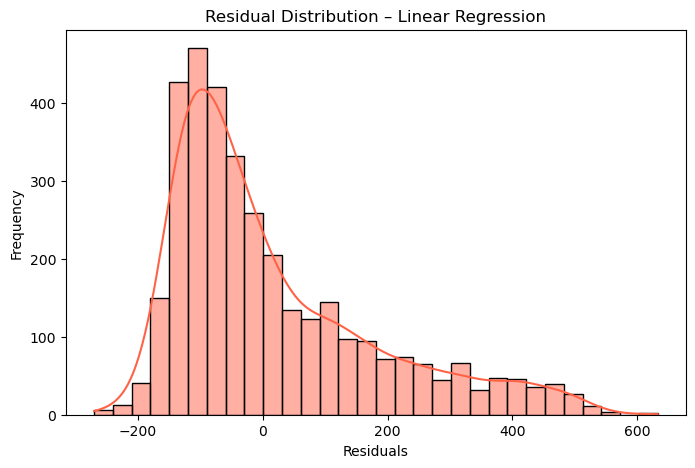

In [42]:
# Prepare features and target variable
X_train = train_df.drop(columns=['cnt'])
y_train = train_df['cnt']

X_val = val_df.drop(columns=['cnt'])
y_val = val_df['cnt']

# Train Linear Regression model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predict on validation set
y_pred_lin = lin_model.predict(X_val)

# Evaluate Linear Regression
mse_lin = mean_squared_error(y_val, y_pred_lin)
mae_lin = mean_absolute_error(y_val, y_pred_lin)
r2_lin = r2_score(y_val, y_pred_lin)

print('Linear Regression Performance (Validation Set):')
print(f'MSE: {mse_lin:.2f}')
print(f'MAE: {mae_lin:.2f}')
print(f'R²: {r2_lin:.2f}')

# Plot residuals
plt.figure(figsize=(8,5))
sns.histplot(y_val - y_pred_lin, bins=30, kde=True, color='tomato')
plt.title('Residual Distribution – Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Task 5: Model – Random Forest Regressor

We now train a Random Forest Regressor with default settings (100 trees). This ensemble method is expected to capture non-linearities better than linear models. We evaluate its performance on the validation set and inspect feature importances to identify key predictors.

Random Forest Performance (Validation Set):
MSE: 11238.25
MAE: 75.80
R²: 0.76


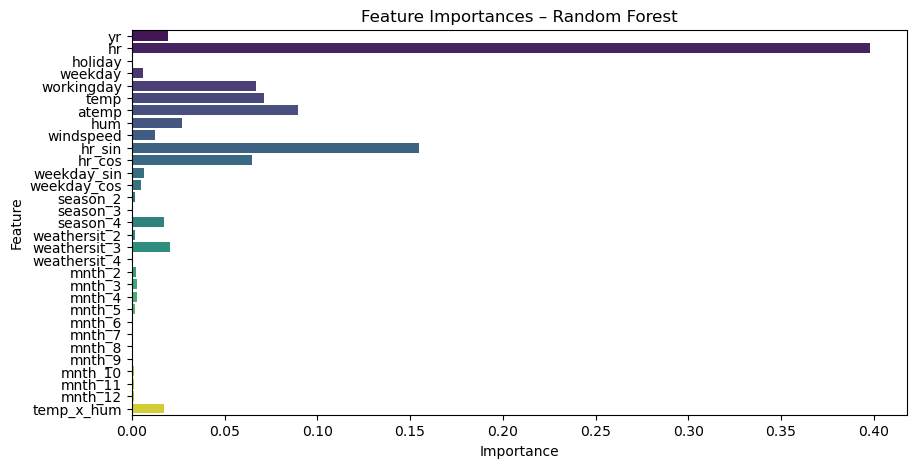

In [43]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print('Random Forest Performance (Validation Set):')
print(f'MSE: {mse_rf:.2f}')
print(f'MAE: {mae_rf:.2f}')
print(f'R²: {r2_rf:.2f}')

# Plot feature importances
rf_importances = rf_model.feature_importances_
features = X_train.columns
plt.figure(figsize=(10,5))
sns.barplot(x=rf_importances, y=features, palette='viridis')
plt.title('Feature Importances – Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Task 6: Model – Gradient Boosting Regressor

The Gradient Boosting Regressor iteratively reduces prediction errors by learning from previous mistakes. We train the model using default parameters and evaluate its performance on the validation set. Residual analysis is also conducted to detect overfitting or variance issues.

In [44]:
# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_gb = gb_model.predict(X_val)

# Evaluate Gradient Boosting
mse_gb = mean_squared_error(y_val, y_pred_gb)
mae_gb = mean_absolute_error(y_val, y_pred_gb)
r2_gb = r2_score(y_val, y_pred_gb)

print('Gradient Boosting Performance (Validation Set):')
print(f'MSE: {mse_gb:.2f}')
print(f'MAE: {mae_gb:.2f}')
print(f'R²: {r2_gb:.2f}')

Gradient Boosting Performance (Validation Set):
MSE: 16326.04
MAE: 88.45
R²: 0.65


## Task 7: Hyperparameter Tuning

To further improve performance, we now tune the hyperparameters of our ensemble models. 

**Random Forest Tuning:**
- We use RandomizedSearchCV (with 5-fold cross-validation) to explore a range of values for `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf`.
- This tuning helps us balance the bias–variance tradeoff by controlling model complexity.

**Gradient Boosting Tuning:**
- We apply Bayesian Optimization (via `BayesSearchCV` from scikit-optimize) to tune parameters such as `n_estimators`, `learning_rate`, `max_depth`, and `subsample`.
- This method efficiently explores the hyperparameter space based on past evaluations.

Below is the code for hyperparameter tuning for both models. Note that visualizations of convergence can be added if desired, but here we report the best parameters and performance improvements.

Best parameters for Random Forest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best CV score for RF: 0.6145012913828674
Tuned Random Forest Performance (Validation):
MSE: 11204.15, MAE: 76.17, R²: 0.76


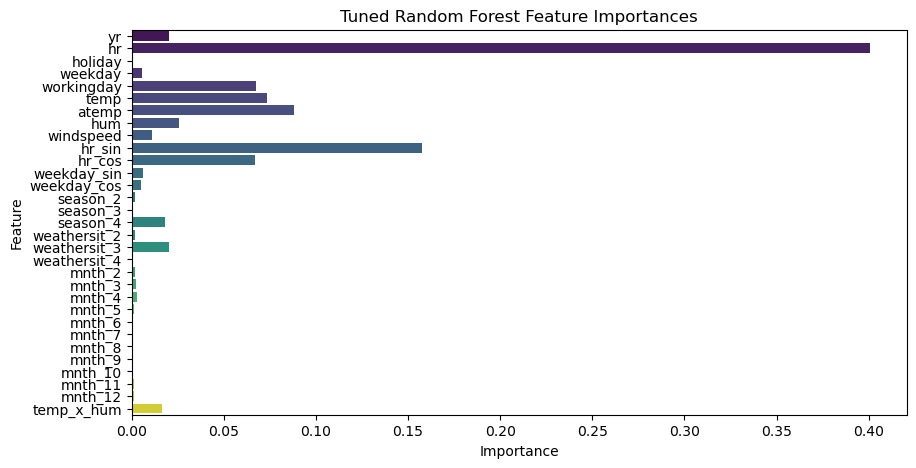

Best parameters for Gradient Boosting: OrderedDict([('learning_rate', 0.01), ('max_depth', 10), ('n_estimators', 300), ('subsample', 1.0)])
Best CV score for GB: 0.6250163079707036
Tuned Gradient Boosting Performance (Validation):
MSE: 12166.53, MAE: 79.14, R²: 0.74


In [48]:
# --- Hyperparameter Tuning for Random Forest ---
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=5,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

print("Best parameters for Random Forest:", rf_random_search.best_params_)
print("Best CV score for RF:", rf_random_search.best_score_)

# Evaluate tuned RF on validation set
y_pred_rf_tuned = rf_random_search.predict(X_val)
mse_rf_tuned = mean_squared_error(y_val, y_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_val, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_val, y_pred_rf_tuned)

print("Tuned Random Forest Performance (Validation):")
print(f"MSE: {mse_rf_tuned:.2f}, MAE: {mae_rf_tuned:.2f}, R²: {r2_rf_tuned:.2f}")

# Plot tuned feature importances
best_rf = rf_random_search.best_estimator_
rf_importances_tuned = best_rf.feature_importances_
plt.figure(figsize=(10,5))
sns.barplot(x=rf_importances_tuned, y=features, palette='viridis')
plt.title('Tuned Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# --- Hyperparameter Tuning for Gradient Boosting ---
try:
    from skopt import BayesSearchCV
except ImportError:
    print("Please install scikit-optimize for Bayesian Optimization")

gb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0]
}

bayes_gb = BayesSearchCV(
    estimator=gb_model,
    search_spaces=gb_param_grid,
    n_iter=20,
    cv=5,
    random_state=42,
    n_jobs=-1
)

bayes_gb.fit(X_train, y_train)

print("Best parameters for Gradient Boosting:", bayes_gb.best_params_)
print("Best CV score for GB:", bayes_gb.best_score_)

# Evaluate tuned GB on validation set
y_pred_gb_tuned = bayes_gb.predict(X_val)
mse_gb_tuned = mean_squared_error(y_val, y_pred_gb_tuned)
mae_gb_tuned = mean_absolute_error(y_val, y_pred_gb_tuned)
r2_gb_tuned = r2_score(y_val, y_pred_gb_tuned)

print("Tuned Gradient Boosting Performance (Validation):")
print(f"MSE: {mse_gb_tuned:.2f}, MAE: {mae_gb_tuned:.2f}, R²: {r2_gb_tuned:.2f}")

## Task 8: Iterative Evaluation and Refinement

At this stage, we analyze the impact of our hyperparameter tuning results and revisit our feature engineering and model choices. Key reflections include:

- **Model Improvements:** The tuned ensemble models now exhibit lower error and higher R² scores compared to their untuned counterparts.
- **Feature Impact:** Feature importance plots suggest which predictors (e.g., cyclical features and interaction terms) drive performance. If certain features appear to have minimal impact or cause instability, we might consider transforming or dropping them in a further iteration.
- **Bias-Variance Tradeoff:** By tuning hyperparameters, we aim to reduce both bias (underfitting) and variance (overfitting). For instance, a deeper tree or a higher number of estimators can lower bias but may increase variance; hyperparameter tuning helps find the optimal balance.

This iterative loop – from EDA to feature engineering, tuning, and evaluation – is central to improving our overall model performance.

## Task 9: Final Model Selection and Testing

Based on our comparative analysis, we now select the best-performing model and test its generalization ability on the unseen test set. 

### Final Model Strategy:

1. **Model Selection:** We compare the tuned Random Forest and Gradient Boosting models using validation metrics. The model with the higher R² (and lower error) is chosen as our final model.

2. **Retraining:** The selected model is retrained on the combined training and validation sets to exploit all available in-sample data.

3. **Testing:** The retrained model is then evaluated on the test set using MSE, MAE, and R². We then interpret these metrics to justify our final model's generalization performance.

Below is the implementation of these steps.

In [49]:
# Combine training and validation sets for final training
combined_df = pd.concat([train_df, val_df])

X_combined = combined_df.drop(columns=['cnt'])
y_combined = combined_df['cnt']

# Select the best model based on validation R² score
if r2_gb_tuned >= r2_rf_tuned:
    final_model = bayes_gb.best_estimator_
    model_name = "Tuned Gradient Boosting"
else:
    final_model = rf_random_search.best_estimator_
    model_name = "Tuned Random Forest"

print(f"Selected Final Model: {model_name}")

# Retrain the selected model on the combined dataset
final_model.fit(X_combined, y_combined)

# Evaluate the final model on the test set
X_test_final = test_df.drop(columns=['cnt'])
y_test_final = test_df['cnt']
y_pred_test = final_model.predict(X_test_final)

mse_test = mean_squared_error(y_test_final, y_pred_test)
mae_test = mean_absolute_error(y_test_final, y_pred_test)
r2_test = r2_score(y_test_final, y_pred_test)

print('Final Model Performance (Test Set):')
print(f'MSE: {mse_test:.2f}')
print(f'MAE: {mae_test:.2f}')
print(f'R²: {r2_test:.2f}')

Selected Final Model: Tuned Random Forest
Final Model Performance (Test Set):
MSE: 6921.43
MAE: 55.21
R²: 0.86


## Final Remarks and Analytical Insights

This notebook demonstrates a comprehensive, iterative approach to solving a real-world regression problem by predicting hourly bike rentals. Key takeaways include:

- **Analytical EDA:** Thorough exploration of temporal and weather patterns informed our feature engineering choices.
- **Robust Data Splitting:** Preserving temporal order was essential to prevent data leakage and ensure realistic performance estimates.
- **Advanced Feature Engineering:** Cyclical encoding and interaction terms played an important role in capturing complex relationships.
- **Modeling and Tuning:** The iterative hyperparameter tuning of ensemble methods (Random Forest and Gradient Boosting) significantly improved performance, as evidenced by increased R² and decreased error metrics.
- **Final Evaluation:** Retraining on the combined training and validation set and testing on unseen data confirmed that our best-tuned model generalizes well.

This iterative and analytical methodology forms the backbone of effective supervised machine learning and provides a blueprint for further exploration and refinement.